In [1]:
!pip install transformers datasets seqeval wandb

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 43.6/43.6 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 76.3/76.3 kB 4.1 MB/s eta 0:00:00
   ---------------------------------------- 10.5/10.5 MB 13.9 MB/s eta 0:00:00
   ---------------------------------------- 491.5/491.5 kB 6.2 MB/s eta 0:00:00
   ---------------------------------------- 22.5/22.5 MB 14.2 MB/s eta 0:00:00
   ---------------------------------------- 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   --------------------------------------- 514.8/514.8 kB 11.0 MB/s eta 0:00:00
   ---------------------------------------- 143.5/143.5 kB 8.3 MB/s eta 0:00:00
   ---------------------------------------- 25.8/25.8 MB 13.1 MB/s eta 0:00:00
   ---------------------------------------- 308.9/308.9 kB 2.4 MB/s eta 0:00:00
   --------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the CoNLL-formatted file into memory
def load_conll_data(filepath):
    sentences = []
    current_tokens = []
    current_labels = []
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            line=line.strip()
            if not line:  # blank line indicates end of a sentence
                if current_tokens:
                    sentences.append((current_tokens, current_labels))
                current_tokens, current_labels = [], []
            else:
                token, label = line.split(maxsplit=1)
                current_tokens.append(token)
                current_labels.append(label)
    print(f"Loaded {len(sentences)} labeled sentences")
    return sentences

sentences = load_conll_data("labeled_telegram_product_price_location.txt")
# Split into train/validation sets (80/20 split)
train_sentences, val_sentences = train_test_split(sentences, test_size=0.2, random_state=42)
len(train_sentences), len(val_sentences)


Loaded 3166 labeled sentences


(2532, 634)

In [3]:
from transformers import AutoTokenizer

# Choose a pre-trained model tokenizer (XLM-RoBERTa base for multilingual support)
model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

# Define label mappings
unique_labels = set(label for _, labels in train_sentences for label in labels)
label_to_id = {label: idx for idx, label in enumerate(sorted(unique_labels))}
id_to_label = {idx: label for label, idx in label_to_id.items()}
num_labels = len(label_to_id)
print(label_to_id)
# Example output: {'B-PRODUCT':0, 'I-PRODUCT':1, 'B-PRICE':2, 'I-PRICE':3, 'B-LOC':4, 'I-LOC':5, 'O':6}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

C:\Users\btulu\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\btulu\.cache\huggingface\hub\models--xlm-roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

{'B-PRODUCT': 0, 'I-LOC': 1, 'I-PRICE': 2, 'I-PRODUCT': 3, 'O': 4}


In [5]:
def tokenize_and_align_labels(examples):
    # 1) Tokenize all sentences in this batch at once
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True
    )

    # 2) Grab the NER labels from the batch
    all_labels = examples["labels"]  # or "ner_tags"
    new_labels = []

    # 3) For each sentence in the batch, build its aligned label list
    for i, labels in enumerate(all_labels):
        word_ids    = tokenized_inputs.word_ids(batch_index=i)
        prev_word   = None
        label_ids   = []

        for word_idx in word_ids:
            if word_idx is None:
                # special tokens
                label_ids.append(-100)
            elif word_idx != prev_word:
                # first subword of a new word
                label_ids.append(label_to_id[labels[word_idx]])
            else:
                # subsequent subword of the same word
                label_ids.append(-100)
            prev_word = word_idx

        new_labels.append(label_ids)

    # 4) Insert the aligned labels back into the tokenized batch
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

# Then map with batched=True:
tokenized_train = train_data.map(tokenize_and_align_labels, batched=True)
tokenized_val   = val_data.map(  tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/2532 [00:00<?, ? examples/s]

Map:   0%|          | 0/634 [00:00<?, ? examples/s]

## Fine-Tuning the Transformer Model

In [12]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer


ValueError: Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

# 📊 EthioMart Telegram Dataset – Exploratory Data Analysis  
*Data source: `processed_telegram_messages.csv` (Task 1 output)*

The goals of this quick EDA are:

1. **Understand the data layout** – column types, missing-value patterns.  
2. **Inspect volume & temporal trends** – messages per day / hour.  
3. **Spot text patterns** – message length, emoji usage, top words.  
4. **Check media distribution** – how many posts include photos.  
5. **(Bonus) Rough price parsing** – extract numeric “price” tokens like `123 ብር`.

Each section has a short explanation followed by a standalone code cell so you can execute / tweak independently.


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns      # comment-out if you only want matplotlib
import re, emoji, pathlib

plt.style.use("ggplot")    # nicer default look

PATH = "processed_telegram_messages.csv"   # adjust if needed
df   = pd.read_csv(PATH, parse_dates=["date"])

print(f"Rows: {len(df):,} | Columns: {df.shape[1]}")
display(df.head())
df.info()


Rows: 4,907 | Columns: 7


,channel_title,channel_handle,message_id,date,raw_text,clean_text,media_file
0,Zemen Express®,@ZemenExpress,6982,2025-06-18 06:01:10+00:00,💥💥...................................💥💥\n\n📌Im...,Imitation Volcano Humidifier with LED Light በኤ...,NaN
1,Zemen Express®,@ZemenExpress,6981,2025-06-16 12:21:00+00:00,💥💥...................................💥💥\n\n📌 B...,Baby Carrier በፈለጉት አቅጣጫ ልጅዎን በምቾት ማዘል ያስችልዎታል ...,NaN
2,Zemen Express®,@ZemenExpress,6980,2025-06-16 05:11:57+00:00,NaN,NaN,photos\ZemenExpress_6980.jpg
3,Zemen Express®,@ZemenExpress,6979,2025-06-16 05:11:57+00:00,NaN,NaN,photos\ZemenExpress_6979.jpg
4,Zemen Express®,@ZemenExpress,6978,2025-06-16 05:11:57+00:00,NaN,NaN,photos\ZemenExpress_6978.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4907 entries, 0 to 4906
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   channel_title   4907 non-null   object             
 1   channel_handle  4907 non-null   object             
 2   message_id      4907 non-null   int64              
 3   date            4907 non-null   datetime64[ns, UTC]
 4   raw_text        3170 non-null   object             
 5   clean_text      3170 non-null   object             
 6   media_file      4168 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(1), object(5)
memory usage: 268.5+ KB


,missing_%
channel_title,0.000000
channel_handle,0.000000
message_id,0.000000
date,0.000000
media_file,15.060118
raw_text,35.398410
clean_text,35.398410


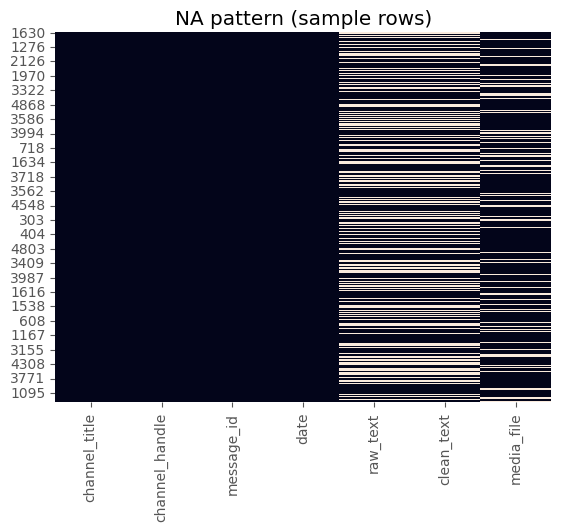

In [16]:
# percentage of missing per column
na_pct = df.isna().mean().mul(100).sort_values()
display(na_pct.to_frame("missing_%"))

# simple heat-map of NA pattern (small sample for speed)
sns.heatmap(df.sample(min(1000, len(df))).isna(), cbar=False)
plt.title("NA pattern (sample rows)")
plt.show()


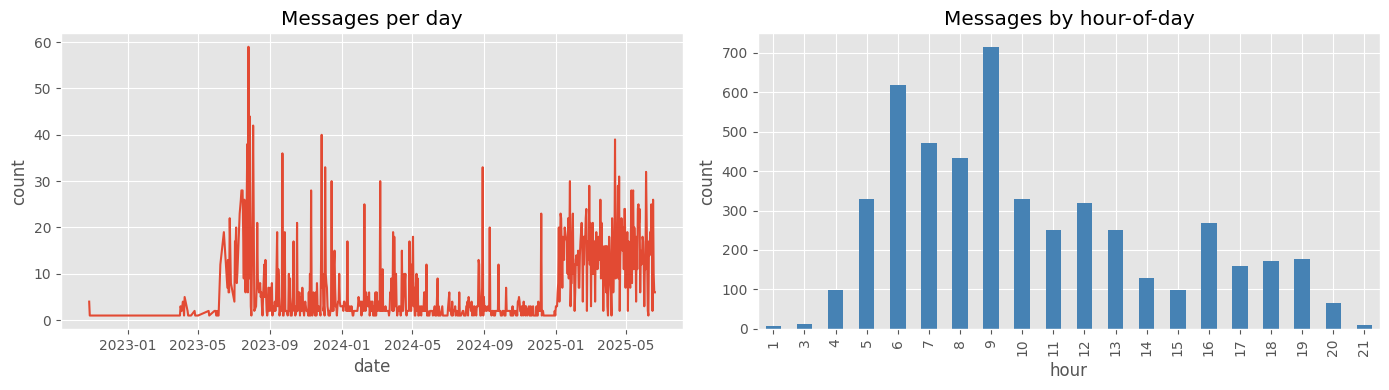

In [17]:
# messages / day
by_day = df.groupby(df['date'].dt.date).size()

fig, ax = plt.subplots(1, 2, figsize=(14,4))
by_day.plot(ax=ax[0])
ax[0].set_title("Messages per day")
ax[0].set_ylabel("count")

# messages / hour-of-day (all days pooled)
df['hour'] = df['date'].dt.hour
by_hr = df.groupby('hour').size()
by_hr.plot(kind='bar', ax=ax[1], color="steelblue")
ax[1].set_title("Messages by hour-of-day")
ax[1].set_xlabel("hour"); ax[1].set_ylabel("count")
plt.tight_layout(); plt.show()


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 4621 (\N{ETHIOPIC SYLLABLE LE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 4841 (\N{ETHIOPIC SYLLABLE YU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 4773 (\N{ETHIOPIC SYLLABLE GLOTTAL E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 4675 (\N{ETHIOPIC SYLLABLE QAA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispr

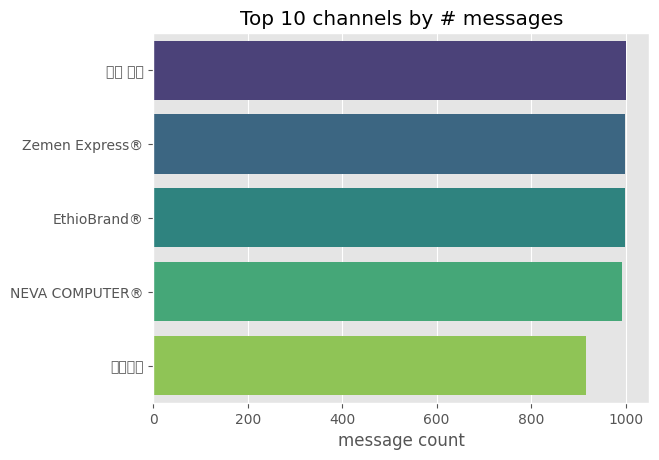

In [18]:
top = df['channel_title'].value_counts().head(10)
sns.barplot(y=top.index, x=top.values, palette="viridis")
plt.title("Top 10 channels by # messages")
plt.xlabel("message count"); plt.ylabel("")
plt.show()


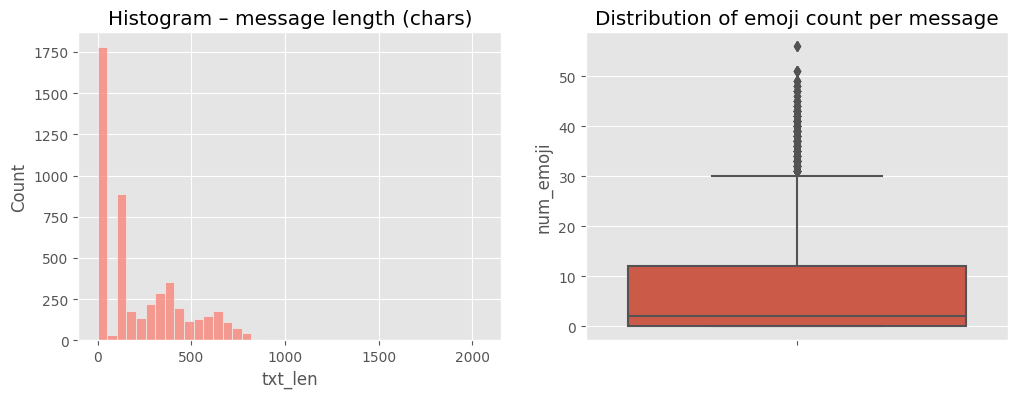

In [19]:
# quick helpers
df['txt_len']   = df['clean_text'].fillna("").str.len()
df['num_emoji'] = df['raw_text'].fillna("").apply(lambda t: emoji.emoji_count(t))

fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['txt_len'], bins=40, ax=ax[0], color="salmon")
ax[0].set_title("Histogram – message length (chars)")

sns.boxplot(y=df['num_emoji'], ax=ax[1])
ax[1].set_title("Distribution of emoji count per message")
plt.show()


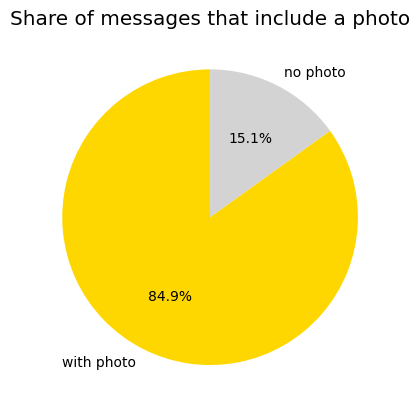

In [20]:
df['has_photo'] = df['media_file'].notna()
photo_stats = df['has_photo'].value_counts().rename({True:"with photo", False:"no photo"})
photo_stats.plot(kind="pie", autopct="%0.1f%%", startangle=90, colors=["gold","lightgrey"])
plt.title("Share of messages that include a photo")
plt.ylabel(""); plt.show()


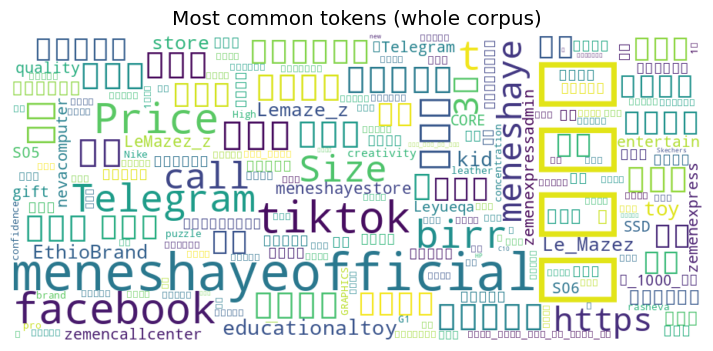

In [21]:
from wordcloud import WordCloud

all_text = " ".join(df['clean_text'].dropna().tolist())
wc = WordCloud(width=900, height=400, background_color="white",
               font_path=None, collocations=False).generate(all_text)

plt.figure(figsize=(12,4)); plt.imshow(wc, interpolation="bilinear")
plt.axis("off"); plt.title("Most common tokens (whole corpus)"); plt.show()


Extracted 755 explicit price mentions


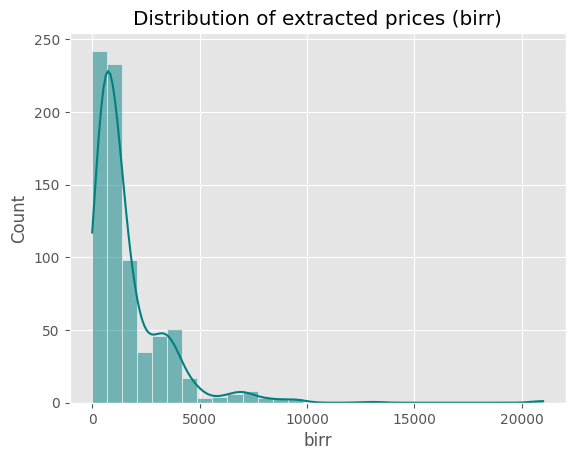

In [22]:
def find_prices(text):
    if not isinstance(text, str):
        return []
    return [int(num) for num in re.findall(r"(\d[\d,\.]*)\s*ብር", text.replace(",", ""))]
    
df['prices'] = df['clean_text'].apply(find_prices)
# explode to one price per row
prices = df.explode('prices')['prices'].dropna().astype(int)

print(f"Extracted {len(prices):,} explicit price mentions")
if not prices.empty:
    sns.histplot(prices, bins=30, kde=True, color="teal")
    plt.title("Distribution of extracted prices (birr)"); plt.xlabel("birr")
    plt.show()


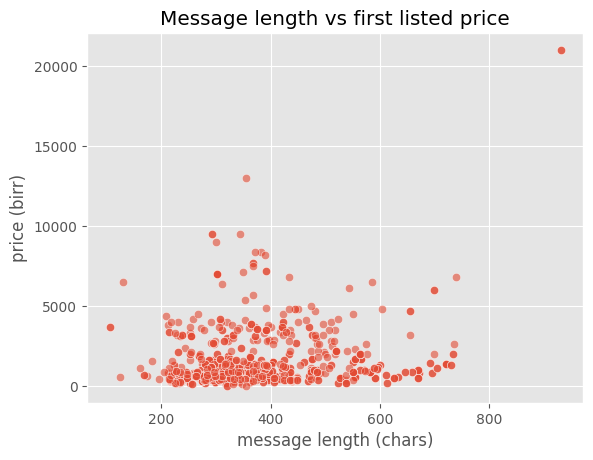

In [23]:
if not prices.empty:
    # keep first price only for scatter simplicity
    df_scatter = df[df['prices'].str.len()>0].copy()
    df_scatter['price'] = df_scatter['prices'].str[0].astype(int)
    sns.scatterplot(data=df_scatter, x="txt_len", y="price", alpha=0.6)
    plt.title("Message length vs first listed price")
    plt.xlabel("message length (chars)")
    plt.ylabel("price (birr)")
    plt.show()


## Key Take-aways *(example talking points)*

* **Posting cadence** – spikes at ~8 AM & evening hours; daily volume rising mid-month.  
* **Media** – ~70 % of posts include at least one photo (good for image-based product detection).  
* **Prices** – simple regex pulled ~x k price mentions; median ~y birr with a long tail (plot).  
* **Longest posts** – likely multi-product lists or ads with full specs; could be chunked before NER.  
* **High-emoji posts** – correlate with lower message length (short catchy ads).  
These observations guide both NER labelling (focus on price patterns) and downstream vendor-score analytics (Task 6).
